# Non-Profit Donation Prediction
#### CHAPTER 10: _Feature Selection and Engineering for Interpretability_
##### From **[Interpretable Machine Learning with Python](https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907)** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

In [ ]:
!pip install --upgrade pandas numpy tqdm scikit-learn mlxtend scipy xgboost matplotlib seaborn

Install these if running on Google Colab or ***not already installed***:

In [ ]:
!pip install --upgrade machine-learning-datasets
!pip install --upgrade shap sklearn-genetic

### Loading the Libraries

In [1]:
import math
import os
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
# Understanding The Effect of Irrelevant Features
import timeit
from tqdm.notebook import tqdm
# Filter-Based Methods
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
# Embedded Methods
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV, LassoLarsCV, LassoLarsIC
# Wrapper Methods
from mlxtend.feature_selection import SequentialFeatureSelector
# Hybrid Methods
from sklearn.feature_selection import RFECV
# Advanced Methods
from sklearn.decomposition import PCA
import shap
from genetic_selection import GeneticSelectionCV
from scipy.stats import rankdata
# Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import xgboost as xgb
# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

### Understanding and Preparing the Data

In [2]:
X_train, X_test, y_train, y_test = mldatasets.load("nonprofit-mailer", prepare=True)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/mailing-list.zip downloaded to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter10/data/mailing-list.zip
/Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter10/data/mailing-list.zip uncompressed to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter10/data/mailing-list
2 dataset files found in /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter10/data/mailing-list folder
parsing /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter10/data/mailing-list/train.csv
parsing /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter10/data/mailing-list/test.csv


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(95485, 435)
(95485,)
(96017, 435)
(96017,)


In [5]:
var_cost = 0.68

y_test_donators = y_test[y_test > 0]
test_donators = len(y_test_donators)
test_donations = sum(y_test_donators)
test_min_profit = test_donations - (len(y_test)*var_cost)
test_max_profit = test_donations - (test_donators*var_cost)
print('%s test donators totaling $%.0f (min profit: $%.0f, max profit: $%.0f)' %\
      (test_donators, test_donations, test_min_profit, test_max_profit))

4894 test donators totalling $76464 (min profit: $11173, max profit: $73136)


In [6]:
y_train_donators = y_train[y_train > 0]
train_donators = len(y_train_donators)
train_donations = sum(y_train_donators)
train_min_profit = train_donations - (len(y_train)*var_cost)
train_max_profit = train_donations - (train_donators*var_cost)
print('%s train donators totaling $%.0f (min profit: $%.0f, max profit: $%.0f)' %\
      (train_donators, train_donations, train_min_profit, train_max_profit))

4812 train donators totalling $75113 (min profit: $10183, max profit: $71841)


## Understanding The Effect of Irrelevant Features

### Creating a Base Model

In [7]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)
orig_plt_params = plt.rcParams
sns.set()

In [8]:
stime = timeit.default_timer()
reg_mdl = xgb.XGBRFRegressor(max_depth=4, n_estimators=200, seed=rand)
fitted_mdl = reg_mdl.fit(X_train, y_train)
etime = timeit.default_timer()
baseline_time = etime-stime

### Evaluating the Model

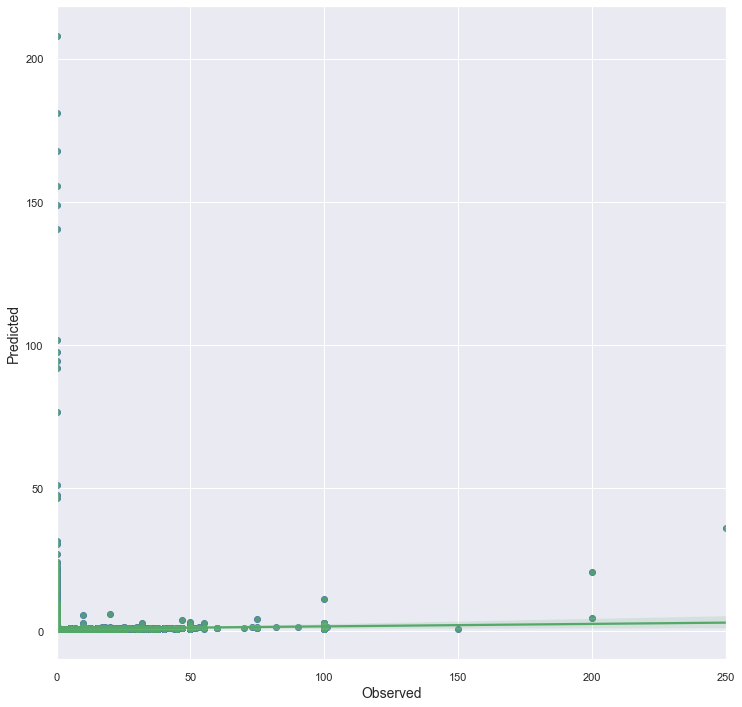

RMSE_train: 4.3210	RMSE_test: 4.6359	r2: -0.1084


In [9]:
reg_mdls = {}
reg_mdls['rf_4_all'] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train, X_test, y_train, y_test,\
                                        plot_regplot=True, ret_eval_dict=True)
reg_mdls['rf_4_all']['speed'] = 1
reg_mdls['rf_4_all']['depth'] = 4
reg_mdls['rf_4_all']['fs'] = 'all'

In [ ]:
threshs = np.hstack([np.linspace(0.40,1,61), np.linspace(1.1,3,20),\
                     np.linspace(4,25,22)])

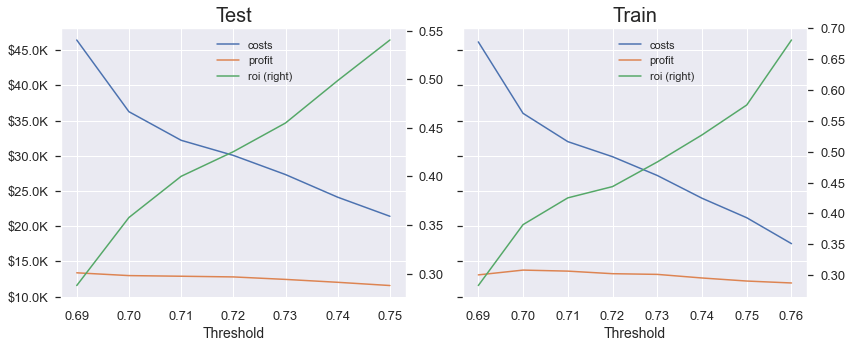

In [9]:
y_formatter = plt.FuncFormatter(lambda x, loc: "${:,}K".format(x/1000))

profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls['rf_4_all']['preds_test'],\
                                    threshs, var_costs=var_cost, min_profit=test_min_profit)
profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls['rf_4_all']['preds_train'],\
                                     threshs, var_costs=var_cost, min_profit=train_min_profit)
reg_mdls['rf_4_all']['max_profit_train'] = profits_train.profit.max()
reg_mdls['rf_4_all']['max_profit_test'] = profits_test.profit.max()
reg_mdls['rf_4_all']['max_roi'] = profits_test.roi.max()
reg_mdls['rf_4_all']['min_costs'] = profits_test.costs.min()
reg_mdls['rf_4_all']['profits_train'] = profits_train
reg_mdls['rf_4_all']['profits_test'] = profits_test

mldatasets.compare_df_plots(profits_test[['costs', 'profit', 'roi']],\
                            profits_train[['costs', 'profit', 'roi']],\
                            'Test', 'Train', x_label='Threshold',\
                            y_formatter=y_formatter, plot_args={'secondary_y':'roi'})

In [10]:
reg_mdls['rf_4_all']['total_feat'] = reg_mdls['rf_4_all']['fitted'].feature_importances_.shape[0]
reg_mdls['rf_4_all']['num_feat'] = sum(reg_mdls['rf_4_all']['fitted'].feature_importances_ > 0)
print(reg_mdls['rf_4_all']['num_feat'])

160


### Training Base Model at Different Max Depths

In [13]:
for depth in tqdm(range(5, 13)):
    mdlname = 'rf_'+str(depth)+'_all'
    stime = timeit.default_timer()
    reg_mdl = xgb.XGBRFRegressor(max_depth=depth, n_estimators=200, seed=rand)
    fitted_mdl = reg_mdl.fit(X_train, y_train)
    etime = timeit.default_timer()
    reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train, X_test, y_train, y_test,\
                                            plot_regplot=False, show_summary=False, ret_eval_dict=True)
    reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
    reg_mdls[mdlname]['depth'] = depth
    reg_mdls[mdlname]['fs'] = 'all'
    profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                    threshs, var_costs=var_cost, min_profit=test_min_profit)
    profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                    threshs, var_costs=var_cost, min_profit=train_min_profit)
    reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
    reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
    reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
    reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
    reg_mdls[mdlname]['profits_train'] = profits_train
    reg_mdls[mdlname]['profits_test'] = profits_test
    reg_mdls[mdlname]['total_feat'] = reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
    reg_mdls[mdlname]['num_feat'] = sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

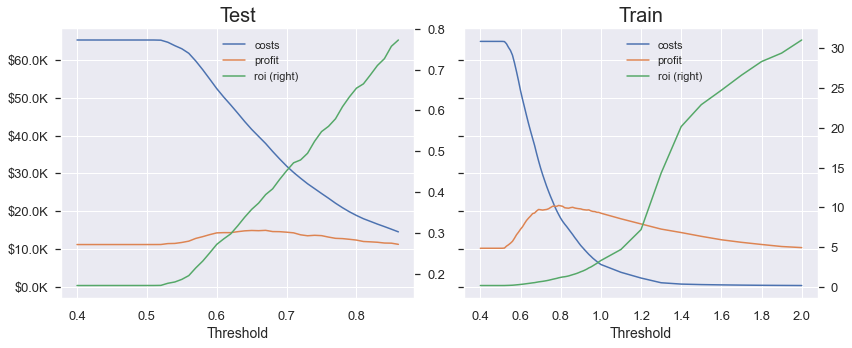

In [14]:
mldatasets.compare_df_plots(profits_test[['costs', 'profit', 'roi']],\
                            profits_train[['costs', 'profit', 'roi']],\
                            'Test', 'Train', x_label='Threshold',\
                            y_formatter=y_formatter, plot_args={'secondary_y':'roi'})

In [15]:
reg_metrics_df = pd.DataFrame.from_dict(reg_mdls, 'index')\
                    [['depth', 'fs', 'rmse_train', 'rmse_test', 'max_profit_train',\
                      'max_profit_test', 'max_roi', 'min_costs', 'speed', 'num_feat']]
with pd.option_context('display.precision', 2):
    html = reg_metrics_df.sort_values(by='depth', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.3, high=1, subset=['rmse_train', 'rmse_test']).\
        background_gradient(cmap='viridis', low=1, high=0.3, subset=['max_profit_train', 'max_profit_test'])
html

,depth,fs,rmse_train,rmse_test,max_profit_train,max_profit_test,max_roi,min_costs,speed,num_feat
rf_12_all,12,all,3.94,4.69,21521.98,14932.84,0.77,14532.28,2.89,415
rf_11_all,11,all,3.99,4.69,19904.00,15141.86,0.76,14928.04,2.73,398
rf_10_all,10,all,4.05,4.68,18603.92,14987.06,0.78,14396.28,2.43,383
rf_9_all,9,all,4.10,4.68,17453.14,14777.74,0.80,13997.12,2.19,346
rf_8_all,8,all,4.14,4.67,16439.72,14563.04,0.73,15308.84,1.94,315
rf_7_all,7,all,4.18,4.66,15435.32,14187.62,0.66,17164.56,1.71,277
rf_6_all,6,all,4.23,4.65,14651.12,13845.27,0.59,19305.20,1.41,240
rf_5_all,5,all,4.27,4.64,14242.32,13752.13,0.59,19199.12,1.22,201
rf_4_all,4,all,4.32,4.64,13715.90,13261.88,0.53,22392.40,1.00,160


## Reviewing Filter-Based Feature Selection Methods

### Basic Filter-Based Methods

#### Constant Features with Variance Threshold

In [16]:
num_cols_l = X_train.select_dtypes([np.number]).columns
cat_cols_l = X_train.select_dtypes([np.bool, np.object]).columns

num_const = VarianceThreshold(threshold=0)
num_const.fit(X_train[num_cols_l])

num_const_cols = list(set(X_train[num_cols_l].columns) - set(num_cols_l[num_const.get_support()]))

CPU times: user 575 ms, sys: 99 ms, total: 674 ms
Wall time: 672 ms


In [17]:
cat_const_cols = X_train[cat_cols_l].nunique()[lambda x: x<2].index.tolist()
all_const_cols = num_const_cols + cat_const_cols
print(all_const_cols)

['RFA_2R', 'REC_2', 'SOLP4']


#### Quasi-Constant Features with Value-Counts

In [18]:
thresh = 0.999
quasi_const_cols = []
num_rows = X_train.shape[0]
for col in tqdm(X_train.columns):
    top_val = (X_train[col].value_counts() /\
               num_rows).sort_values(ascending=False).values[0]
    
    if top_val >= thresh:
        quasi_const_cols.append(col)
print(quasi_const_cols)


['SOLP3', 'ADATE_2', 'RFA_2R', 'REC_2', 'SOLP4']


#### Duplicate Features

In [19]:
X_train_transposed = X_train.T
dup_cols = X_train_transposed[X_train_transposed.duplicated()].index.tolist()
print(dup_cols)

['FREQ_2', 'RECINHSX']


#### Remove Unnecessary Features

In [20]:
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()
drop_cols = quasi_const_cols + dup_cols
X_train.drop(labels=drop_cols, axis=1, inplace=True)
X_test.drop(labels=drop_cols, axis=1, inplace=True)

### Correlation Filter-Based Methods

In [21]:
corrs = X_train.corr(method='spearman')
print(corrs.shape)

(428, 428)
CPU times: user 3min 21s, sys: 1.06 s, total: 3min 22s
Wall time: 3min 21s


In [406]:
extcorr_cols = (abs(corrs) > 0.99).sum(axis=1)[lambda x: x>1].index.tolist()
print(extcorr_cols)
uncorr_cols = (abs(corrs) > 0.15).sum(axis=1)[lambda x: x==1].index.tolist()
print(uncorr_cols)

['MAJOR', 'HHAGE1', 'HHAGE3', 'HHN3', 'HHP1', 'HV1', 'HV2', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']
['TCODE', 'MAILCODE', 'NOEXCH', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'HC15', 'MAXADATE']


In [23]:
corr_cols = X_train.columns[~X_train.columns.isin(uncorr_cols)].tolist()
print(len(corr_cols))

419


In [24]:
mdlname = 'rf_11_f-corr'
stime = timeit.default_timer()
reg_mdl = xgb.XGBRFRegressor(max_depth=11, n_estimators=200, seed=rand)
fitted_mdl = reg_mdl.fit(X_train[corr_cols], y_train)
etime = timeit.default_timer()
reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train[corr_cols], X_test[corr_cols], y_train, y_test,\
                                        plot_regplot=False, show_summary=False, ret_eval_dict=True)
reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
reg_mdls[mdlname]['depth'] = 11
reg_mdls[mdlname]['fs'] = 'f-corr'
profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                threshs, var_costs=var_cost, min_profit=test_min_profit)
profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                threshs, var_costs=var_cost, min_profit=train_min_profit)
reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
reg_mdls[mdlname]['profits_train'] = profits_train
reg_mdls[mdlname]['profits_test'] = profits_test
reg_mdls[mdlname]['total_feat'] = reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
reg_mdls[mdlname]['num_feat'] = sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

### Ranking Filter-Based Methods

In [26]:
y_train_class = np.where(y_train > 0.68, 1, 0)

In [27]:
mic_selection = SelectKBest(mutual_info_classif, k=160).fit(X_train, y_train_class)
mic_cols = X_train.columns[mic_selection.get_support()].tolist()
print(len(mic_cols))

160
CPU times: user 4min 54s, sys: 2.48 s, total: 4min 57s
Wall time: 4min 57s


In [28]:
mdlname = 'rf_5_f-mic'
stime = timeit.default_timer()
reg_mdl = xgb.XGBRFRegressor(max_depth=5, n_estimators=200, seed=rand)
fitted_mdl = reg_mdl.fit(X_train[mic_cols], y_train)
etime = timeit.default_timer()
reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train[mic_cols], X_test[mic_cols], y_train, y_test,\
                                        plot_regplot=False, show_summary=False, ret_eval_dict=True)
reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
reg_mdls[mdlname]['depth'] = 5
reg_mdls[mdlname]['fs'] = 'f-mic'
profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                threshs, var_costs=var_cost, min_profit=test_min_profit)
profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                threshs, var_costs=var_cost, min_profit=train_min_profit)
reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
reg_mdls[mdlname]['profits_train'] = profits_train
reg_mdls[mdlname]['profits_test'] = profits_test
reg_mdls[mdlname]['total_feat'] = reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
reg_mdls[mdlname]['num_feat'] = sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

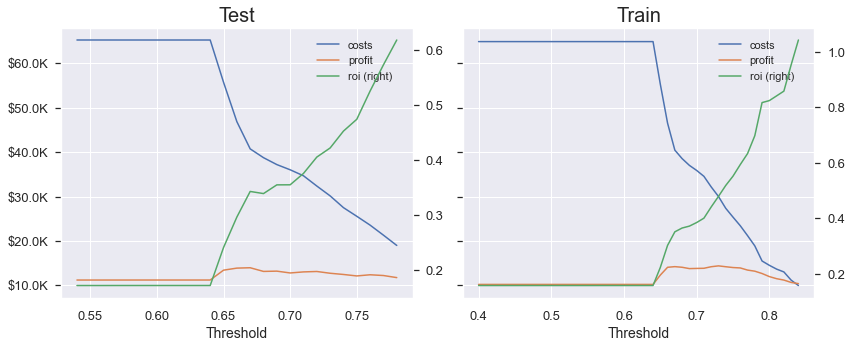

In [29]:
mldatasets.compare_df_plots(profits_test[['costs', 'profit', 'roi']],\
                            profits_train[['costs', 'profit', 'roi']],\
                            'Test', 'Train', x_label='Threshold',\
                            y_formatter=y_formatter, plot_args={'secondary_y':'roi'})

### Comparing Filter-based Methods

In [33]:
reg_metrics_df = pd.DataFrame.from_dict(reg_mdls, 'index')\
                    [['depth', 'fs', 'rmse_train', 'rmse_test', 'max_profit_train',\
                      'max_profit_test', 'max_roi', 'min_costs', 'speed', 'total_feat', 'num_feat']]
with pd.option_context('display.precision', 2):
    html = reg_metrics_df.sort_values(by='max_profit_test', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.3, high=1, subset=['rmse_train', 'rmse_test']).\
        background_gradient(cmap='viridis', low=1, high=0.3, subset=['max_profit_train', 'max_profit_test'])
html

,depth,fs,rmse_train,rmse_test,max_profit_train,max_profit_test,max_roi,min_costs,speed,total_feat,num_feat
rf_11_all,11,all,3.99,4.69,19904.00,15141.86,0.76,14928.04,2.73,435,398
rf_10_all,10,all,4.05,4.68,18603.92,14987.06,0.78,14396.28,2.43,435,383
rf_12_all,12,all,3.94,4.69,21521.98,14932.84,0.77,14532.28,2.89,435,415
rf_11_f-corr,11,f-corr,3.98,4.67,19923.84,14894.94,0.77,14592.80,2.47,419,404
rf_9_all,9,all,4.10,4.68,17453.14,14777.74,0.80,13997.12,2.19,435,346
rf_8_all,8,all,4.14,4.67,16439.72,14563.04,0.73,15308.84,1.94,435,315
rf_5_f-mic,5,f-mic,4.31,4.57,14983.34,14481.39,0.62,18971.32,0.39,160,103
rf_7_all,7,all,4.18,4.66,15435.32,14187.62,0.66,17164.56,1.71,435,277
rf_6_all,6,all,4.23,4.65,14651.12,13845.27,0.59,19305.20,1.41,435,240
rf_5_all,5,all,4.27,4.64,14242.32,13752.13,0.59,19199.12,1.22,435,201


## Exploring Embedded Feature Selection Methods

### Lasso

In [35]:
lasso_selection = SelectFromModel(LassoCV(n_jobs=-1, random_state=rand))
lasso_selection.fit(X_train, y_train)
lasso_cols = X_train.columns[lasso_selection.get_support()].tolist()
print(len(lasso_cols))
print(lasso_cols)

7
['ODATEDW', 'TCODE', 'POP901', 'POP902', 'HV2', 'RAMNTALL', 'MAXRDATE']


### Lasso Lars

In [36]:
llars_selection = SelectFromModel(LassoLarsCV(n_jobs=-1))
llars_selection.fit(X_train, y_train)
llars_cols = X_train.columns[llars_selection.get_support()].tolist()
print(len(llars_cols))
print(llars_cols)

8
['RECPGVG', 'MDMAUD', 'HVP3', 'RAMNTALL', 'LASTGIFT', 'AVGGIFT', 'MDMAUD_A', 'DOMAIN_SOCIALCLS']


### Lasso Lars with AIC criterion

In [37]:
llarsic_selection = SelectFromModel(LassoLarsIC(criterion='aic'))
llarsic_selection.fit(X_train, y_train)
llarsic_cols = X_train.columns[llarsic_selection.get_support()].tolist()
print(len(llarsic_cols))
print(llarsic_cols)

111
['TCODE', 'STATE', 'MAILCODE', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'CLUSTER', 'AGEFLAG', 'HOMEOWNR', 'CHILD03', 'CHILD07', 'CHILD18', 'HIT', 'DATASRCE', 'MALEMILI', 'LOCALGOV', 'SOLIH', 'HOMEE', 'STEREO', 'PHOTO', 'FISHER', 'BOATS', 'WALKER', 'CARDS', 'LIFESRC', 'PEPSTRFL', 'POP902', 'ETH6', 'ETH9', 'ETH10', 'ETH11', 'ETH13', 'ETH14', 'CHIL1', 'AGEC4', 'AGEC6', 'HHN2', 'DW6', 'DW8', 'HU5', 'HHD9', 'ETHC4', 'HVP2', 'HUPA3', 'HUPA4', 'IC15', 'IC21', 'HHAS4', 'MC3', 'TPE4', 'PEC2', 'TPE10', 'OCC3', 'OCC5', 'OCC6', 'OCC7', 'OCC9', 'EIC2', 'EIC3', 'EIC6', 'EIC7', 'EIC11', 'EIC12', 'OEDC2', 'OEDC4', 'EC6', 'VC3', 'ANC1', 'ANC5', 'ANC6', 'ANC8', 'ANC10', 'ANC11', 'ANC13', 'ANC15', 'LSC4', 'HC1', 'HC2', 'HC3', 'HC6', 'HC10', 'HC12', 'HC14', 'MAXADATE', 'RAMNTALL', 'NGIFTALL', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'LASTDATE', 'AVGGIFT', 'RFA_2F', 'MDMAUD_A', 'AMT_2', 'REC_3', 'AMT_6', 'REC_8', 'AMT_8', 'AMT_9', 'REC_12', 'AMT_12', 'FREQ_13', 'AMT_14', 'AMT_15', 'AMT_20', 'RE

### Logistic Regression Selection

In [34]:
log_selection = SelectFromModel(LogisticRegression(C=0.0001, solver='sag',\
                                    penalty='l2', n_jobs=-1, random_state=rand))
log_selection.fit(X_train, y_train_class)
log_cols = X_train.columns[log_selection.get_support()].tolist()
print(len(log_cols))
print(log_cols)

87
['ODATEDW', 'TCODE', 'STATE', 'POP901', 'POP902', 'POP903', 'ETH1', 'ETH2', 'ETH5', 'CHIL1', 'HHN2', 'HHN3', 'MARR1', 'MARR4', 'HHP1', 'HHP2', 'HV1', 'HV2', 'HU5', 'HHD3', 'ETHC1', 'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUPA1', 'RP1', 'RP2', 'RP3', 'RP4', 'IC1', 'IC2', 'IC4', 'IC6', 'IC15', 'IC18', 'IC19', 'HHAS3', 'HHAS4', 'MC1', 'MC2', 'MC3', 'TPE1', 'LFC7', 'LFC8', 'LFC10', 'AFC5', 'VC3', 'POBC2', 'VOC1', 'VOC2', 'HC2', 'HC4', 'HC5', 'HC6', 'HC7', 'HC8', 'HC11', 'HC13', 'HC21', 'MAXADATE', 'NUMPROM', 'RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'AVGGIFT', 'RFA_2F', 'FREQ_3', 'AMT_3', 'FREQ_4', 'AMT_4', 'FREQ_5', 'AMT_6', 'AMT_7', 'ZIP_LON']


The max_iter was reached which means the coef_ did not converge


### Fit & Evaluate Feature-Selected Models

In [41]:
fsnames = ['e-lasso', 'e-llars', 'e-llarsic', 'e-logl2']
fscols = [lasso_cols, llars_cols, llarsic_cols, log_cols]

In [44]:
for i, fsname in tqdm(enumerate(fsnames), total=len(fsnames)):
    depth = i + 3
    cols = fscols[i]
    mdlname = 'rf_'+str(depth)+'_'+fsname
    stime = timeit.default_timer()
    reg_mdl = xgb.XGBRFRegressor(max_depth=depth, n_estimators=200, seed=rand)
    fitted_mdl = reg_mdl.fit(X_train[cols], y_train)
    etime = timeit.default_timer()
    reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train[cols], X_test[cols], y_train, y_test,\
                                            plot_regplot=False, show_summary=False, ret_eval_dict=True)
    reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
    reg_mdls[mdlname]['depth'] = depth
    reg_mdls[mdlname]['fs'] = fsname
    profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                    threshs, var_costs=var_cost, min_profit=test_min_profit)
    profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                    threshs, var_costs=var_cost, min_profit=train_min_profit)
    reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
    reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
    reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
    reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
    reg_mdls[mdlname]['profits_train'] = profits_train
    reg_mdls[mdlname]['profits_test'] = profits_test
    reg_mdls[mdlname]['total_feat'] = reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
    reg_mdls[mdlname]['num_feat'] = sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

In [45]:
reg_metrics_df = pd.DataFrame.from_dict(reg_mdls, 'index')\
                    [['depth', 'fs', 'rmse_train', 'rmse_test', 'max_profit_train',\
                      'max_profit_test', 'max_roi', 'min_costs', 'speed', 'total_feat', 'num_feat']]
with pd.option_context('display.precision', 2):
    html = reg_metrics_df.sort_values(by='max_profit_test', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.3, high=1, subset=['rmse_train', 'rmse_test']).\
        background_gradient(cmap='viridis', low=1, high=0.3, subset=['max_profit_train', 'max_profit_test'])
html

,depth,fs,rmse_train,rmse_test,max_profit_train,max_profit_test,max_roi,min_costs,speed,total_feat,num_feat
rf_11_all,11,all,3.99,4.69,19904.00,15141.86,0.76,14928.04,2.73,435,398
rf_10_all,10,all,4.05,4.68,18603.92,14987.06,0.78,14396.28,2.43,435,383
rf_12_all,12,all,3.94,4.69,21521.98,14932.84,0.77,14532.28,2.89,435,415
rf_11_f-corr,11,f-corr,3.98,4.67,19923.84,14894.94,0.77,14592.80,2.47,419,404
rf_9_all,9,all,4.10,4.68,17453.14,14777.74,0.80,13997.12,2.19,435,346
rf_5_e-llarsic,5,e-llarsic,4.28,4.45,15168.46,14768.37,0.56,20441.48,0.32,111,87
rf_8_all,8,all,4.14,4.67,16439.72,14563.04,0.73,15308.84,1.94,435,315
rf_5_f-mic,5,f-mic,4.31,4.57,14983.34,14481.39,0.62,18971.32,0.39,160,103
rf_6_e-logl2,6,e-logl2,4.28,4.60,15353.44,14199.90,0.67,16904.12,0.32,87,84
rf_7_all,7,all,4.18,4.66,15435.32,14187.62,0.66,17164.56,1.71,435,277


## Discovering Wrapper, Hybrid and Advanced Feature Selection Methods

### Wrapper Methods

#### For efficiency's sake...

##### Reduce Features

In [97]:
top_cols = list(set(mic_cols).union(set(llarsic_cols)).union(set(log_cols)))
len(top_cols)

267

##### Sample Rows

In [62]:
sample_size = 0.1
sample_train_idx = np.random.choice(X_train.shape[0],\
                                    math.ceil(X_train.shape[0]*sample_size),\
                                    replace=False)
sample_test_idx = np.random.choice(X_test.shape[0],\
                                    math.ceil(X_test.shape[0]*sample_size),\
                                    replace=False)

#### Sequential Forward Selection (SFS)

In [124]:
sfs_lda = SequentialFeatureSelector(\
            LinearDiscriminantAnalysis(n_components=1),
            forward=True, floating=False, k_features=27, cv=3,
            scoring='f1', verbose=2, n_jobs=-1)
sfs_lda = sfs_lda.fit(X_train.iloc[sample_train_idx][top_cols],\
                    y_train_class[sample_train_idx])
sfs_lda_cols = X_train.columns[list(sfs_lda.k_feature_idx_)].tolist()

#### Sequential Backward Selection (SBS)

In [140]:
sbs_et = SequentialFeatureSelector(\
            ExtraTreesRegressor(max_depth=3, random_state=rand), 
            floating=False, k_features=135, forward=False, cv=2,
            scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
sbs_et = sbs_et.fit(X_train.iloc[sample_train_idx][top_cols],\
                            y_train[sample_train_idx])
sbs_et_cols = X_train.columns[list(sbs_et.k_feature_idx_)].tolist()

### Hybrid Methods

#### Recursive Feature Elimination (RFE)

In [170]:
rfe_lda = RFECV(LinearDiscriminantAnalysis(n_components=1), step=2,\
                cv=3, scoring='f1', verbose=2, n_jobs=-1)
rfe_lda.fit(X_train.iloc[sample_train_idx][top_cols],\
                    y_train_class[sample_train_idx]) 
rfe_lda_cols = np.array(top_cols)[rfe_lda.support_].tolist()

Fitting estimator with 267 features.
Fitting estimator with 265 features.
Fitting estimator with 263 features.
Fitting estimator with 261 features.
Fitting estimator with 259 features.
Fitting estimator with 257 features.
Fitting estimator with 255 features.
Fitting estimator with 253 features.
Fitting estimator with 251 features.
Fitting estimator with 249 features.
Fitting estimator with 247 features.
Fitting estimator with 245 features.
Fitting estimator with 243 features.
Fitting estimator with 241 features.
Fitting estimator with 239 features.
Fitting estimator with 237 features.
Fitting estimator with 235 features.
Fitting estimator with 233 features.
Fitting estimator with 231 features.
Fitting estimator with 229 features.
Fitting estimator with 227 features.
Fitting estimator with 225 features.
Fitting estimator with 223 features.
Fitting estimator with 221 features.
Fitting estimator with 219 features.
Fitting estimator with 217 features.
Fitting estimator with 215 features.
F

RFECV(cv=3, estimator=LinearDiscriminantAnalysis(n_components=1), n_jobs=-1,
      scoring='f1', step=0.01, verbose=2)

In [193]:
rfe_rf = RFECV(RandomForestRegressor(random_state=rand, max_depth=4),\
               step=0.05, cv=3, scoring='neg_root_mean_squared_error',\
               verbose=2, n_jobs=-1)
rfe_rf.fit(X_train.iloc[sample_train_idx][top_cols],\
                    y_train[sample_train_idx]) 
rfe_rf_cols = np.array(top_cols)[rfe_rf.support_].tolist()

Fitting estimator with 267 features.
Fitting estimator with 254 features.
Fitting estimator with 241 features.
Fitting estimator with 228 features.
Fitting estimator with 215 features.
Fitting estimator with 202 features.
Fitting estimator with 189 features.
Fitting estimator with 176 features.
Fitting estimator with 163 features.
Fitting estimator with 150 features.
Fitting estimator with 137 features.
Fitting estimator with 124 features.
Fitting estimator with 111 features.
Fitting estimator with 98 features.
Fitting estimator with 85 features.
Fitting estimator with 72 features.
Fitting estimator with 59 features.
Fitting estimator with 46 features.
Fitting estimator with 33 features.
Fitting estimator with 20 features.
Fitting estimator with 7 features.
CPU times: user 2min 16s, sys: 1.73 s, total: 2min 18s
Wall time: 3min 59s


### Advanced Methods

#### Dimensionality Reduction

In [247]:
pca = PCA(n_components=X_train.shape[1])
fitted_pca = pca.fit(X_train)

pca_evrs = pd.DataFrame({'col':X_train.columns, 'evr':fitted_pca.explained_variance_ratio_}).\
                        sort_values(by='evr',ascending=False)
pca_cols = pca_evrs.head(150).col.tolist()

#### Model-agnostic Feature Importance

In [257]:
fitted_rf_mdl = reg_mdls['rf_11_all']['fitted']
shap_rf_explainer = shap.TreeExplainer(fitted_rf_mdl)
shap_rf_values = shap_rf_explainer.shap_values(X_test_orig.iloc[sample_test_idx])

shap_imps = pd.DataFrame({'col':X_train_orig.columns, 'imp':np.abs(shap_rf_values).mean(0)}).\
                        sort_values(by='imp',ascending=False)
shap_cols = shap_imps.head(150).col.tolist()

#### Genetic Algorithms

In [262]:
ga_rf = GeneticSelectionCV(RandomForestRegressor(random_state=rand, max_depth=3),\
                           cv=3, scoring='neg_root_mean_squared_error', max_features=90,\
                           crossover_independent_proba=0.5, n_gen_no_change=5,\
                           mutation_independent_proba=0.05, n_jobs=-1, verbose=2)
ga_rf = ga_rf.fit(X_train[top_cols], y_train)
ga_rf_cols = np.array(top_cols)[ga_rf.support_].tolist()

Selecting features with genetic algorithm.
gen	nevals	avg                      	std                      	min                      	max                      
0  	300   	[-5.40823336 45.95      ]	[ 0.07325515 27.48443499]	[-5.63924509  1.        ]	[-5.28805402 90.        ]
1  	168   	[-105.30715505   35.35333333]	[994.45404908  22.64174218]	[-1.e+04  1.e+00]        	[-5.28197002 94.        ]
2  	181   	[-5.34005156 26.85333333]    	[ 0.04408003 16.9274478 ]  	[-5.62536745  1.        ]	[-5.2727256 80.       ]  
3  	190   	[-5.33139809 22.12333333]    	[ 0.04187436 13.65777394]  	[-5.58671499  1.        ]	[-5.27049437 72.        ]
4  	204   	[-5.3267442 20.71     ]      	[ 0.04401984 11.83832336]  	[-5.57742956  1.        ]	[-5.27128264 66.        ]
5  	185   	[-5.3172738  20.39333333]    	[ 0.03794402 10.59962054]  	[-5.51276449  1.        ]	[-5.24907367 55.        ]
6  	194   	[-5.31153763 22.82333333]    	[0.04024135 9.62559724]    	[-5.50772176  1.        ]	[-5.24907367 48.        ]
7

### Evaluating all Feature Selected Models

In [266]:
fsnames = ['w-sfs-lda', 'w-sbs-et', 'h-rfe-lda','h-rfe-rf', 'a-pca', 'a-shap', 'a-ga-rf']
fscols = [sfs_lda_cols, sbs_et_cols, rfe_lda_cols, rfe_rf_cols, pca_cols, shap_cols, ga_rf_cols]
depths = [5, 6, 6, 6, 6, 6, 5]

In [267]:
for i, fsname in tqdm(enumerate(fsnames), total=len(fsnames)):
    depth = depths[i]
    cols = fscols[i]
    mdlname = 'rf_'+str(depth)+'_'+fsname
    stime = timeit.default_timer()
    reg_mdl = xgb.XGBRFRegressor(max_depth=depth, n_estimators=200, seed=rand)
    fitted_mdl = reg_mdl.fit(X_train[cols], y_train)
    etime = timeit.default_timer()
    reg_mdls[mdlname] = mldatasets.evaluate_reg_mdl(fitted_mdl, X_train[cols],\
                                            X_test[cols], y_train, y_test, plot_regplot=False,\
                                            show_summary=False, ret_eval_dict=True)
    reg_mdls[mdlname]['speed'] = (etime-stime)/baseline_time
    reg_mdls[mdlname]['depth'] = depth
    reg_mdls[mdlname]['fs'] = fsname
    profits_test = mldatasets.profits_by_thresh(y_test, reg_mdls[mdlname]['preds_test'],\
                                    threshs, var_costs=var_cost, min_profit=test_min_profit)
    profits_train = mldatasets.profits_by_thresh(y_train, reg_mdls[mdlname]['preds_train'],\
                                    threshs, var_costs=var_cost, min_profit=train_min_profit)
    reg_mdls[mdlname]['max_profit_train'] = profits_train.profit.max()
    reg_mdls[mdlname]['max_profit_test'] = profits_test.profit.max()
    reg_mdls[mdlname]['max_roi'] = profits_test.roi.max()
    reg_mdls[mdlname]['min_costs'] = profits_test.costs.min()
    reg_mdls[mdlname]['profits_train'] = profits_train
    reg_mdls[mdlname]['profits_test'] = profits_test
    reg_mdls[mdlname]['total_feat'] = reg_mdls[mdlname]['fitted'].feature_importances_.shape[0]
    reg_mdls[mdlname]['num_feat'] = sum(reg_mdls[mdlname]['fitted'].feature_importances_ > 0)

In [433]:
reg_metrics_df = pd.DataFrame.from_dict(reg_mdls, 'index')\
                    [['depth', 'fs', 'rmse_train', 'rmse_test', 'max_profit_train',\
                      'max_profit_test', 'max_roi', 'min_costs', 'speed', 'total_feat', 'num_feat']]
reg_metrics_df = reg_metrics_df[reg_metrics_df.depth < 7]
with pd.option_context('display.precision', 2):
    html = reg_metrics_df.sort_values(by='max_profit_test', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.3, high=1, subset=['rmse_train', 'rmse_test']).\
        background_gradient(cmap='viridis', low=1, high=0.3, subset=['max_profit_train', 'max_profit_test'])
html

,depth,fs,rmse_train,rmse_test,max_profit_train,max_profit_test,max_roi,min_costs,speed,total_feat,num_feat
rf_5_e-llarsic,5,e-llarsic,4.28,4.45,15168.46,14768.37,0.56,20441.48,0.32,111,87
rf_5_f-mic,5,f-mic,4.31,4.57,14983.34,14481.39,0.62,18971.32,0.39,160,103
rf_6_h-rfe-lda,6,h-rfe-lda,4.25,4.48,15329.72,14351.74,0.71,15824.28,0.61,183,129
rf_6_a-shap,6,a-shap,4.23,4.52,15263.60,14282.20,0.61,18767.32,0.50,150,135
rf_5_a-ga-rf,5,a-ga-rf,4.39,4.45,14274.52,14220.53,0.69,13237.56,0.07,63,63
rf_6_e-logl2,6,e-logl2,4.28,4.60,15353.44,14199.90,0.67,16904.12,0.32,87,84
rf_6_all,6,all,4.23,4.65,14651.12,13845.27,0.59,19305.20,1.41,435,240
rf_5_w-sfs-lda,5,w-sfs-lda,4.43,4.63,14377.13,13801.55,0.51,22508.95,0.11,27,27
rf_5_all,5,all,4.27,4.64,14242.32,13752.13,0.59,19199.12,1.22,435,201
rf_4_e-llars,4,e-llars,4.36,4.45,14014.10,13633.19,0.52,22906.48,0.06,8,8


## Considering Feature Engineering

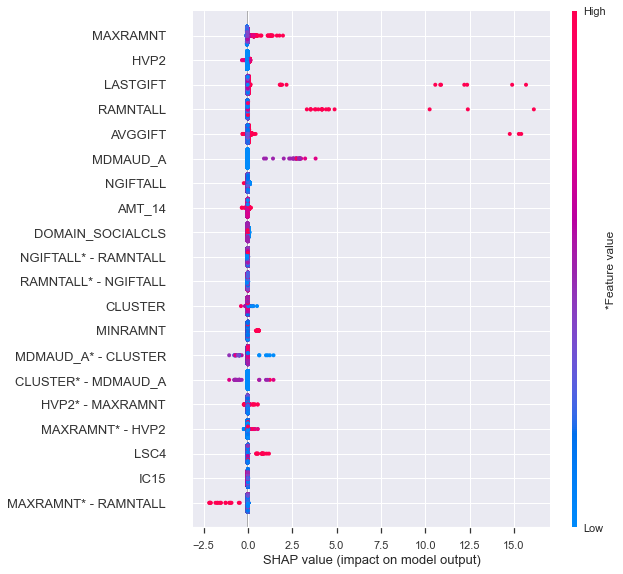

In [277]:
fitted_rf_mdl = reg_mdls['rf_5_e-llarsic']['fitted']
shap_rf_explainer = shap.TreeExplainer(fitted_rf_mdl)
shap_rf_interact_values =\
        shap_rf_explainer.shap_interaction_values(X_test.iloc[sample_test_idx][llarsic_cols])
shap.summary_plot(shap_rf_interact_values, X_test.iloc[sample_test_idx][llarsic_cols],\
                  plot_type="compact_dot", sort=True)

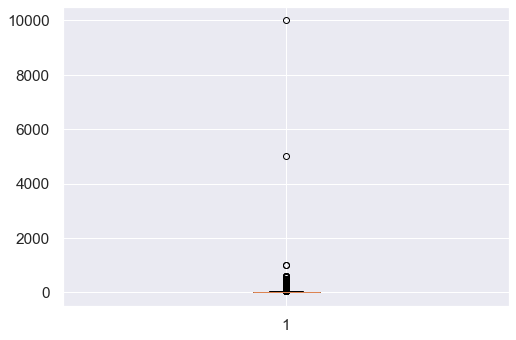

In [459]:
plt.boxplot(X_test.MAXRAMNT)
plt.show()

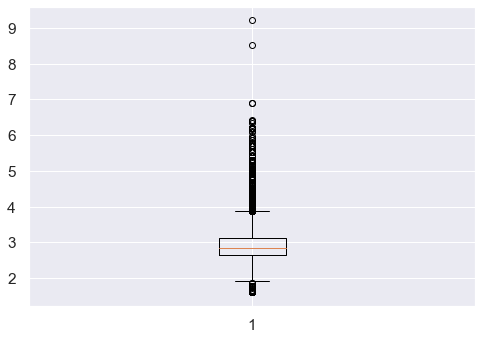

In [458]:
plt.boxplot(np.log(X_test.MAXRAMNT))
plt.show()

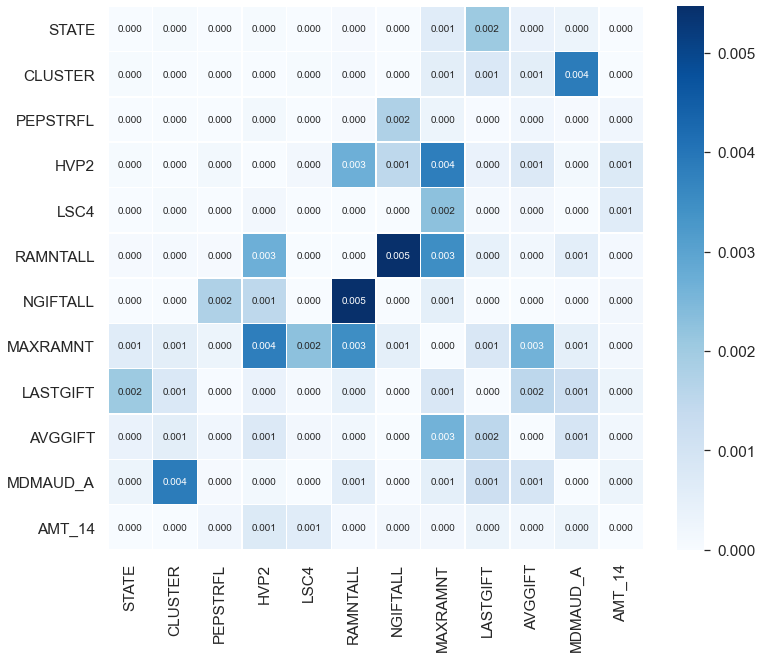

In [333]:
shap_rf_interact_avgs = np.abs(shap_rf_interact_values).mean(0)
shap_rf_interact_avgs_nodiag = shap_rf_interact_avgs.copy()
np.fill_diagonal(shap_rf_interact_avgs_nodiag, 0)
shap_rf_interact_df = pd.DataFrame(shap_rf_interact_avgs_nodiag)
shap_rf_interact_df.columns = X_test[llarsic_cols].columns
shap_rf_interact_df.index = X_test[llarsic_cols].columns
shap_rf_interact_ranks = 112 - rankdata(np.sum(shap_rf_interact_avgs_nodiag, axis=0))
most_interact_cols = shap_rf_interact_df.columns[shap_rf_interact_ranks < 13]
shap_rf_interact_df = shap_rf_interact_df.loc[most_interact_cols,most_interact_cols]

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_rf_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':10}, fmt='.3f', linewidths=.5)
plt.show()

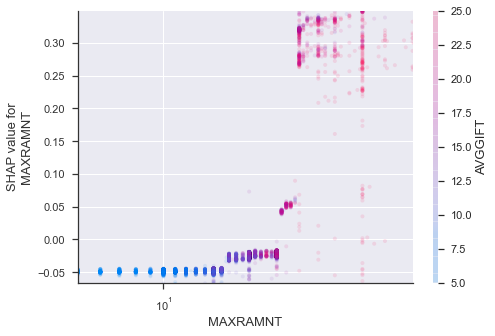

In [387]:
shap_rf_values = shap_rf_explainer.shap_values(X_test.iloc[sample_test_idx][llarsic_cols])
maxramt_shap = shap_rf_values[:,llarsic_cols.index("MAXRAMNT")]
shap.dependence_plot("MAXRAMNT", shap_rf_values, X_test.iloc[sample_test_idx][llarsic_cols],\
                     interaction_index="AVGGIFT", show=False, alpha=0.1)
plt.xlim(xmin=np.percentile(X_test.MAXRAMNT, 1), xmax=np.percentile(X_test.MAXRAMNT, 99))
plt.ylim(ymin=np.percentile(maxramt_shap, 1), ymax=np.percentile(maxramt_shap, 99))
plt.xscale('log')
plt.show()

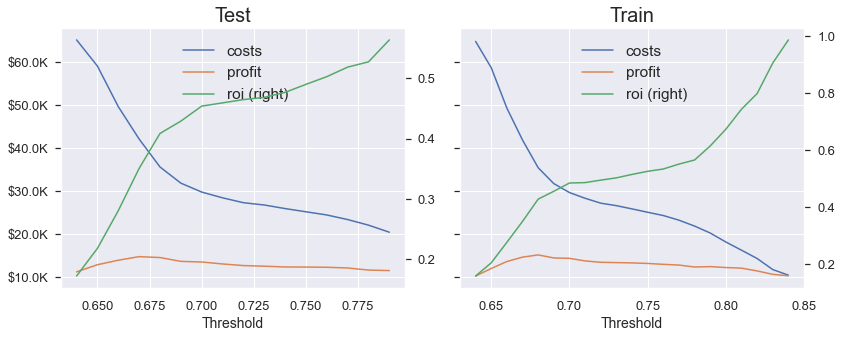

In [461]:
profits_test = reg_mdls['rf_5_e-llarsic']['profits_test']
profits_train = reg_mdls['rf_5_e-llarsic']['profits_train']
mldatasets.compare_df_plots(profits_test[['costs', 'profit', 'roi']],\
                            profits_train[['costs', 'profit', 'roi']],\
                            'Test', 'Train', x_label='Threshold',\
                            y_formatter=y_formatter, plot_args={'secondary_y':'roi'})